In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage import measure
from skimage.color import rgb2grey

from dolfin import *
from mshr import *

289


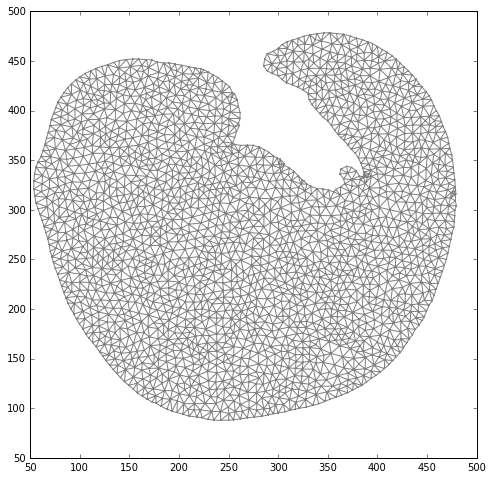

In [5]:
def mesh_from_image(path, n=32, o=1, l=0.8):
    
    r = rgb2grey(mpimg.imread(path))

    # Find contours at a constant value of 0.8
    contours = measure.find_contours(r, l)

    # Select the biggest contour
    max_contour = sorted(contours, key=lambda x:len(x), reverse=True)[0]

    max_contour = max_contour[::8*o]
    # Generate the mesh
    domain_vertices = [Point(x,y) for x,y in max_contour]
    
    print len(domain_vertices)
    geometry = Polygon(domain_vertices)
    mesh = generate_mesh(geometry,n)
    return mesh, max_contour

mesh, domain_vertices = mesh_from_image('embrio.jpg', o=-1, l=0.1)

plt.figure(figsize=(8,8))
plot(mesh)

In [ ]:
# Calculate the eigenfunctions

k = 10 #Which eigenfuncion should we plot, in order of smallest magnitude eigenvalue

V = FunctionSpace(mesh, 'Lagrange', 1)
bc = DirichletBC(V, 0.0, DomainBoundary())
u, v = TrialFunction(V), TestFunction(V)

a = inner(grad(u), grad(v))*dx
L = Constant(0.0)*v*dx
m = u*v*dx

A, _ = assemble_system(a, L, bc)
B = assemble(m)

print "Discrete space size: %d"%V.dim()
eigensolver = SLEPcEigenSolver(as_backend_type(A), as_backend_type(B))
#prm = eigensolver.parameters
#info(prm, True)
eigensolver.parameters['spectrum'] = 'smallest magnitude'

eigensolver.solve(200)
eig = Function(V)
eig_vec = eig.vector()

r, c, rx, cx = eigensolver.get_eigenpair(k)
eig_vec[:] = rx
print r, c
plt.figure()
plot(eig)

In [ ]:
# Save the first eigenfunctions in a folder

j = 30

for n in range(j):
    r, c, rx, cx = eigensolver.get_eigenpair(n)
    eig_vec[:] = rx
    print r, c
    plt.figure()
    plot(eig)
    plt.title('Eigen: %s'%round(r, 6))
    plt.savefig('FolderName/Embrio%d.png'%n)

In [15]:
# Get the area of the mesh
x = domain_vertices[:,0]
y = domain_vertices[:,1]

area = 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
print area

120003.674297


In [ ]:
# Save the eigenvalues and plot them (normalized)

eigenvalues_embrion = []
for n in range(150):
    r, c, rx, cx = eigensolver.get_eigenpair(n)
    eigenvalues_embrion.append(r / area)
    
plt.plot(np.array(list(range(150))), np.array(eigenvalues_embrion))
plt.legend(['Embrio'])
plt.show()